# "Classify" hyb/fu calls

## Prerequisites

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.legend import Legend
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc, gridspec
import matplotlib

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns
from scipy.spatial.distance import euclidean as euclid
from scipy.spatial import distance_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import datetime

from preprocessing_functions import pad_spectro, calc_zscore, create_padded_data

In [264]:
wd = os.getcwd()
DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures", "hybfu")
DF = os.path.join(os.path.sep, DATA, "meerkat_full_specs.pkl")

### Load dataset

On 03.08.2020, generated hyb/fu dataset:

In [113]:
df = pd.read_pickle(DF)

In [114]:
print("Removed unsure: ", df.shape)
df = df.loc[df['certain_yn']=="y"]
print("Removed uncertain: ",df.shape)
df = df.loc[df['nonfocal_yn']=="n"]
print("Removed nonfocal: ",df.shape)
df = df.loc[df['noisy']==0]
print("Removed noisy: ",df.shape)

df = df.loc[df.call_lable == 'fu/hyb',:]

Removed unsure:  (34955, 34)
Removed uncertain:  (34236, 34)
Removed nonfocal:  (26277, 34)
Removed noisy:  (23224, 34)


In [115]:
df

,Name,Start,Duration,Time Format,Type,Description,start_s,duration_s,stop_s,date,...,raw_audio,spectrograms,denoised_spectrograms,stretched_spectrograms,stretched_denoised_spectrograms,stretched_mfccs,mfccs,zmfccs,freq_spectrograms,ampli_spectrograms
806,HYB [LEAD + CC],1:31:41.954,0:00.198,decimal,Cue,NaN,5501.954,0.198,5502.152,2017-09-03,...,"[0.0234375, 0.01953125, 0.0234375, 0.017578125...","[[-10.296639, -11.01328, -11.856265, -11.55906...","[[19.922031, 18.974045, 17.47694, 17.771103, 1...","[[-10.262085, -10.541439, -10.826624, -11.1393...","[[19.922031, 19.770088, 19.430988, 18.89681, 1...","[[-191.55305, -188.89818, -186.42719, -184.115...","[[-191.77162, -185.38849, -180.01454, -177.698...","[[-2.6019833, -1.9347607, -1.3730277, -1.13092...","[[-3.046884, -3.2675705, -4.2775364, -6.571751...","[[1.6788062, 1.6366893, 1.4570282, 1.1188122, ..."
858,HYB [CC + LEAD],1:40:35.456,0:00.159,decimal,Cue,NaN,6035.456,0.159,6035.615,2017-09-03,...,"[0.005859375, 0.0078125, 0.013671875, 0.003906...","[[-11.134404, -10.691081, -10.306575, -9.79993...","[[18.1908, 18.690907, 19.657093, 22.457169, 24...","[[-11.04562, -10.902723, -10.761625, -10.62230...","[[18.190802, 18.598516, 18.877245, 18.712896, ...","[[-181.05461, -181.34912, -181.43413, -181.363...","[[-181.61615, -181.90501, -185.12675, -192.493...","[[-0.9211083, -0.9529426, -1.3079863, -2.11977...","[[-2.0320694, -1.9660487, -1.6529536, -1.28741...","[[1.3648038, 1.3752171, 1.4256929, 1.486973, 1..."
905,HYB [CC + LEAD],1:46:52.050,0:00.150,decimal,Cue,NaN,6412.050,0.150,6412.200,2017-09-03,...,"[0.048828125, 0.029296875, 0.015625, 0.0097656...","[[-9.472719, -9.140013, -9.563782, -12.269596,...","[[26.987646, 27.699198, 28.274994, 27.95655, 2...","[[-9.438492, -9.5038, -9.423682, -9.205869, -9...","[[26.987648, 27.058392, 27.255783, 27.571102, ...","[[-213.716, -214.61201, -215.31651, -215.85448...","[[-213.93246, -216.21945, -222.88977, -232.629...","[[-1.2285227, -1.446509, -2.0823023, -3.010671...","[[-5.0800166, -6.3585854, -9.939966, -14.70943...","[[2.0419326, 1.7624344, 1.1669277, 0.6738609, ..."
1019,HYB [CC + AGG],2:04:50.562,0:00.356,decimal,Cue,NaN,7490.562,0.356,7490.918,2017-09-03,...,"[0.048828125, 0.05859375, 0.044921875, 0.02148...","[[-26.022942, -22.48412, -20.081642, -20.27795...","[[14.142876, 17.734531, 19.777496, 18.85127, 1...","[[-25.89352, -23.313091, -21.281113, -20.00086...","[[14.142872, 16.48354, 18.419048, 19.563057, 1...","[[-249.44923, -248.92159, -246.17273, -242.555...","[[-250.26775, -249.30959, -244.92517, -234.310...","[[-7.3594136, -7.2534213, -6.7684255, -5.59426...","[[-30.086689, -25.215252, -19.306656, -17.4341...","[[0.31092402, 0.5447863, 1.0756129, 1.334384, ..."
1169,HYB (SN+CC),1:00:02.820,0:00.202,decimal,Cue,NaN,3602.820,0.202,3603.022,2017-09-05,...,"[-0.015625, -0.0078125, 0.0, -0.005859375, 0.0...","[[-25.706045, -22.436039, -18.186426, -16.3663...","[[-0.06571579, 2.5547218, 5.8970547, 8.2416935...","[[-25.595936, -24.218006, -22.910671, -21.3316...","[[-0.06571579, 1.0004196, 2.0493698, 3.3920689...","[[-158.65843, -156.77621, -154.46854, -152.420...","[[-159.35483, -153.9816, -149.96982, -151.3003...","[[1.0946515, 1.6524972, 2.069, 1.9308616, 1.71...","[[-23.396921, -20.141174, -15.722856, -12.4238...","[[0.2134532, 0.3105203, 0.51642346, 0.75501406..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34782,HYB [CC+MOV],1:15.173,0:00.138,decimal,Cue,NaN,75.173,0.138,75.311,2017-08-24,...,"[-0.027385592, -0.030448556, -0.034989476, -0....","[[-23.391113, -22.983736, -22.472845, -22.6566...","[[4.636875, 5.5033855, 5.7969894, 5.3307533, 2...","[[-23.386648, -23.272442, -23.1596, -23.048096...","[[4.636877, 4.9087715, 5.1538086, 5.3705463, 5...","[[-170.77318, -170.51335, -169.94894, -169.163...","[[-170.80142, -168.61958, -165.61545, -162.513...","[[1.1903716, 1.4181046, 1.7316672, 2.0554316, ...","[[-24.471397, -29.124962, -34.541447, -24.0903...","[[1.3205173, 0.7727978, 0.4

--> missing information about focal/nonfocal, and denoised_spectrograms (unstretched). Re-do spectrograms based on raw audio, also re-extract focal vs. nonfocal information.

### Remove short and long calls

Text(0, 0.5, 'N. of calls')

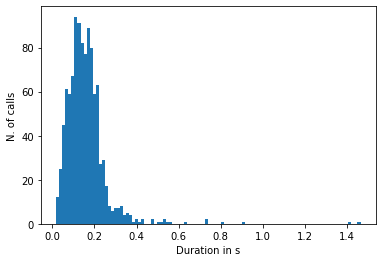

In [127]:
n, bins, pathes = plt.hist(df['duration_s'], bins=100)
plt.xlabel("Duration in s")
plt.ylabel("N. of calls")

In [128]:
MAX_DURATION = 0.5
MIN_DURATION = 0.05

print(df[df['duration_s']>MAX_DURATION].shape[0]/df.shape[0])
print(df[df['duration_s']>MAX_DURATION].shape[0])

df = df.loc[df['duration_s'] <= MAX_DURATION]
df.shape

0.011461318051575931
12


(1035, 34)

In [129]:
print(df[df['duration_s']<MIN_DURATION].shape[0]/df.shape[0]) # % of calls < 0.5s --> 9.4 %
print(df[df['duration_s']<MIN_DURATION].shape[0])

df = df.loc[df['duration_s'] >= MIN_DURATION]
df.shape

0.04057971014492753
42


(993, 34)

# Analysis

## UMAP project_transform

In [112]:
# Load non-hyb/fu dataset
df_clear = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_reduced.pkl"))
df_clear.shape

(6430, 34)

In [130]:
df_hybfu = df
df_hybfu.shape

(993, 34)

In [136]:
specs = df_clear.spectrograms.copy()
specs = [calc_zscore(x) for x in specs] 

# pad feature
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)
data.shape

(6430, 5360)

In [131]:
n_comp = 3
#n_comp = 5

reducer = umap.UMAP(low_memory=True, n_components = n_comp, min_dist=0, random_state=2204)
umap_res = reducer.fit(data)

In [137]:
# Project hyb/fu datapoints into UMAP space:
# Thus need them padded to same length as original specs

hybfu_specs = df_hybfu.spectrograms.copy()
hybfu_specs = [calc_zscore(x) for x in hybfu_specs] 

hybfu_flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in hybfu_specs]
hybfu_data = np.asarray(hybfu_flattened_specs)
hybfu_data.shape

(993, 5360)

In [138]:
hybfu_embeddings = np.zeros((hybfu_data.shape[0],n_comp))

for i in range(hybfu_data.shape[0]):
    print('\rProcessing row ',i, end='')
    hybfu_embeddings[i,:] = umap_res.transform(hybfu_data[i:i+1,])

Processing row  992

In [140]:
np.save(os.path.join(os.path.sep,DATA,'hybfu_embeddings.npy'), hybfu_embeddings)

## Visualize

In [141]:
embedding_non_ambi = umap_res.embedding_
embedding_ambi = hybfu_embeddings

non_ambi_labels = df_clear.call_lable.values
ambi_labelnames = df_hybfu.Name.values
embedded_list = [embedding_non_ambi[i,:] for i in range(embedding_non_ambi.shape[0])]

embedding_all = np.concatenate((embedding_non_ambi, embedding_ambi), axis=0)
labels_all = list(df_clear.call_lable.values)+list(df_hybfu.call_lable.values)

In [144]:
x, y, z = embedding_all[:,0], embedding_all[:,1], embedding_all[:,2] 
scat_labels = labels_all
labeltypes = sorted(list(set(scat_labels)))

labeltypes.remove('fu/hyb') # make these custom


pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))
color_dict['fu/hyb'] = (1,0,0) # make them red
c = [color_dict[val] for val in scat_labels]

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   #hovertext = umap_df.call_lable.values, #+ " (" +umap_df.Name.values+")",
                                   hovertext = df.indv.values+" "+df.Name.values,
                                   marker=dict(
                                       size=4,
                                       color=c,                # set color to an array/list of desired values
                                       #colorscale='Viridis',   # choose a colorscale
                                       opacity=0.8
                                       ))])

fig.update_layout(scene = dict(
                    xaxis_title='UMAP1',
                    yaxis_title='UMAP2',
                    zaxis_title='UMAP3'),
                    #zaxis_title='Duration (s)'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

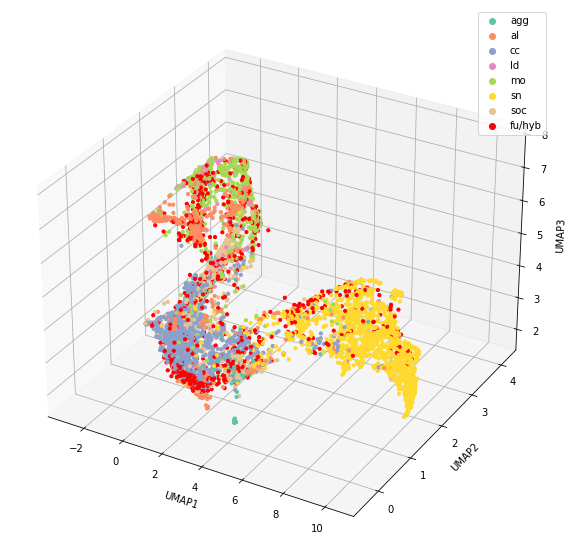

In [147]:
# https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html#matplotlib.axes.Axes.scatter

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

scat_labels = labels_all
labeltypes = sorted(list(set(scat_labels)))

labeltypes.remove('fu/hyb') # make these custom

# makes colors same as AVGN visualization
pal = sns.color_palette("Set2", n_colors=len(labeltypes))
#pal = sns.color_palette("deep", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))

color_dict['fu/hyb'] = (1,0,0) # make them red

c = [color_dict[val] for val in scat_labels]


Axes3D.scatter(ax,
               xs = embedding_all[:,0],
               ys = embedding_all[:,1],
               zs = embedding_all[:,2],
               zdir='z',
               s=10,
               label = c,
               c=c,
               depthshade=False)

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

labeltypes = labeltypes+['fu/hyb']
scatters = []
for label in labeltypes:
    scatters.append(matplotlib.lines.Line2D([0],[0], linestyle="none", c=color_dict[label], marker = 'o'))

ax.legend(scatters, labeltypes, numpoints = 1)

#plt.show()
plt.savefig(os.path.join(os.path.sep,FIGURES,datetime.datetime.today().strftime('%Y-%m-%d')+'_hybfu'))

In [ ]:
def update(i, fig, ax):
    ax.view_init(elev=20., azim=i)
    return fig, ax
 
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), repeat=True, fargs=(fig, ax))

# Save animation
anim.save(FIGURES+datetime.datetime.today().strftime('%Y-%m-%d')+'_hybfu.gif', dpi=80, writer='pillow', fps=12)

## "Classify" fu/hyb based on k nearest neighbor

## Load dataset

In [ ]:
# If starting from here: 

hybfu_classi = pd.read_pickle(os.path.join(os.path.sep, DATA,'2021-07-30_hybfu_classi'))

#df = pd.read_pickle(DATA+'df_denoised_balanced')
#df = df[df.nonfocal_yn == 'n'] # for focal
#df.reset_index(inplace=True)

#df = pd.read_pickle(DATA+'df_focal_hyb_fu') # wrong?
#embedding_ambi = np.load(DATA+'hybfu_embeddings.npy')

#embedding_non_ambi = pd.read_pickle(DATA+'2020-10-14_embedding_denoised_melspectro_focal')
#embedding_non_ambi = np.asarray(embedding_non_ambi)[:,0:5]

#non_ambi_labels = df.call_lable.values
#ambi_labelnames = hybfu_classi.Name.values
#embedded_list = [embedding_non_ambi[i,:] for i in range(embedding_non_ambi.shape[0])]

#hybfu_calls = hybfu_classi['hybfu_type'].map(str) + ':' + hybfu_classi['first_label'].map(str) + '_' + hybfu_classi['second_label'].map(str)
#calltypes = sorted(list(set(hybfu_classi.first_label.values)))

## Or else continue:

In [176]:
# OR IF USED PROJECT_TRANSFORM:

hybfu_classi = df_hybfu

embedding_non_ambi = umap_res.embedding_
embedding_ambi = hybfu_embeddings

non_ambi_labels = df_clear.call_lable.values
ambi_labelnames = df_hybfu.Name.values
embedded_list = [embedding_non_ambi[i,:] for i in range(embedding_non_ambi.shape[0])]

## Identify neighbors

In [177]:
from scipy.spatial.distance import euclidean as euclid
k=5

In [178]:
neighbors = []
neighbor_ids = []

for i in range(embedding_ambi.shape[0]):
    print('\rProcessing row ',i, end='')
    x = embedding_ambi[i,:]
    distances = np.asarray([euclid(x,y) for y in embedded_list])
    neighbor_inds = np.argsort(distances)[:k]
    neighbor_labels = [non_ambi_labels[ind] for ind in neighbor_inds]
    neighbors.append(neighbor_labels)
    neighbor_ids.append(neighbor_inds)

Processing row  992

In [ ]:
#hybfu_classi = df_hybfu

### Make list of hybfu labels

This is a PAIN to automate, because different wordings are used, sometimes there is a space between '+', sometimes not... But ok. There seems to be a systematic such that:

HYB [call1+call2]

fu call1+call2

* Remove all *,?,!, etc.
* Find out whether first word is hyb or fu
* Split everything before first space and everything after
* remove brackets in HYB
* remove all empty spaces
* split words based on +
* categorize labels according to the groups

In [151]:
import re

In [152]:
labelsep = re.compile('[\?\*\!\%\.\$]') # Match ? * ! %
clean_ambi_lables = [labelsep.sub('', i) for i in ambi_labelnames]

In [153]:
firstword = [i.split(' ')[0] for i in clean_ambi_lables]

In [154]:
pd.Series(firstword).value_counts()

fu     737
HYB    256
dtype: int64

In [155]:
clean_ambi_lables = [i.split(' ', 1)[1] for i in clean_ambi_lables]

In [156]:
labelsep = re.compile('[()[\]{}]') # Match brackets
clean_ambi_lables = [labelsep.sub('', i) for i in clean_ambi_lables]

In [157]:
faulty = [x if '+' not in x else x for x in clean_ambi_lables]
pd.Series(faulty).value_counts()

cc+agg      158
SN+CC       140
cc+agg       69
mov+s        61
s+mo         55
           ... 
s+cc          1
MOV+SN        1
cc+agg #      1
ld+s          1
mov+cc        1
Length: 94, dtype: int64

In [158]:
clean_ambi_lables = [x+'+'+x if '+' not in x else x for x in clean_ambi_lables]

In [159]:
first_label = [i.split('+', 1)[0] for i in clean_ambi_lables]
second_label = [i.split('+', 1)[1] for i in clean_ambi_lables]

In [160]:
# Remove all non-alphabaetical
regex = re.compile('[^a-zA-Z]')

first_label = [regex.sub('', i) for i in first_label]
second_label = [regex.sub('', i) for i in second_label]

In [161]:
pd.Series(first_label).value_counts()

cc       321
SN       174
s        138
mov      136
mo        65
soc       63
CC        53
MOV       17
ld         7
al         3
agg        3
LD         3
MOVE       3
MO         2
SOC        2
alarm      1
LEAD       1
AGG        1
dtype: int64

In [162]:
call_types = {
    'cc' :["cc","Marker", "Marque", "CC", "MARKER", "MARQUE"],
    'sn' :["sn","subm", "short","^s$", "s", "SN", "SUBM", "SHORT", "S"], 
    'mo' :["mo", "mov", "move", "MO","MOV","MOVE"],
    'agg':["ag", "agg", "aggress", "chat", "growl","AG","AGG","AGGRESS","CHAT","GROWL"],
    'ld' :["ld","LD","lead","LEAD"],
    'soc':["soc","SOCIAL", "so", "SOC", "social"],
    'al' :["al", "AL","ALARM", "alarm"]#,
    #'fu/hyb': ["fu", "FU", "Fu", 'HYB', 'hyb', 'Hyb']
    }
    
# make dictionary labels to calls
labels_to_calls = dict((v,k) for k in call_types for v in call_types[k])

In [163]:
check = [lable if lable not in labels_to_calls.keys() else "recognized" for lable in first_label]
pd.Series(check).value_counts()

recognized    993
dtype: int64

In [164]:
pd.Series(second_label).value_counts()

agg         273
CC          149
ld          124
s           114
soc          91
mo           68
cc           41
LD           38
AGG          25
mov          17
MOVE         13
MO            7
SOC           6
al            5
UNK           5
MOV           4
LEAD          4
SN            3
ALARM         2
cdeedrr       1
aggoragg      1
md            1
c             1
dtype: int64

In [165]:
check = [lable if lable not in labels_to_calls.keys() else "recognized" for lable in second_label]
pd.Series(check).value_counts()

recognized    984
UNK             5
c               1
md              1
cdeedrr         1
aggoragg        1
dtype: int64

In [166]:
first_label = [labels_to_calls[lable] if lable in labels_to_calls.keys() else "unknown" for lable in first_label]
second_label = [labels_to_calls[lable] if lable in labels_to_calls.keys() else "unknown" for lable in second_label]

In [167]:
pd.Series(second_label).value_counts()

agg        298
cc         190
ld         166
sn         117
mo         109
soc         97
unknown      9
al           7
dtype: int64

In [168]:
hybfu_calls = list(zip(firstword, first_label, second_label))

### Save dataframe

What percentage

In [179]:
hybfu_classi = pd.DataFrame(list(zip(ambi_labelnames, firstword, first_label, second_label)), columns =['Name', 'hybfu_type', 'first_label', 'second_label']) 

In [180]:
for i in range(k):
    hybfu_classi['neighbor_'+str(i+1)] = [neighbor[i] for neighbor in neighbors]

In [181]:
for i in range(k):
    hybfu_classi['neighbor_id_'+str(i+1)] = [neighbor_id[i] for neighbor_id in neighbor_ids]

In [182]:
#hybfu_classi['index_id'] = df_hyb_fu['index_id']
hybfu_classi['callID'] = df_hybfu['callID'].values

In [183]:
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,neighbor_id_2,neighbor_id_3,neighbor_id_4,neighbor_id_5,callID
0,HYB [LEAD + CC],HYB,ld,cc,sn,sn,sn,sn,sn,215,3009,3208,2907,3181,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
1,HYB [CC + LEAD],HYB,cc,ld,agg,soc,mo,soc,soc,4280,2155,561,4151,4154,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
2,HYB [CC + LEAD],HYB,cc,ld,soc,sn,mo,sn,sn,1305,927,3598,635,4738,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
3,HYB [CC + AGG],HYB,cc,agg,soc,agg,agg,agg,soc,1923,4357,4933,1262,1956,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
4,HYB (SN+CC),HYB,sn,cc,ld,soc,soc,soc,soc,4927,787,2330,4897,2039,HM_HRT_R07_20170903-20170908_file_4_(2017_09_0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,HYB [CC+MOV],HYB,cc,mo,soc,cc,cc,sn,soc,4277,5430,5804,289,4137,HM_VLF206_SOUNDFOC_20170824_2_SS___1:15.173
989,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4655,4595,4696,4792,4915,HM_VLF206_SOUNDFOC_20170824_2_SS___1:26.758
990,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4761,4767,4634,4827,4721,HM_VLF206_SOUNDFOC_20170824_2_SS___1:29.641
991,HYB [CC+LD],HYB,cc,ld,cc,soc,cc,cc,cc,5582,3849,6026,6068,5105,HM_VLF206_SOUNDFOC_20170824_2_SS___1:40.316


In [184]:
hybfu_classi.to_pickle(os.path.join(os.path.sep, DATA,'2021-07-30_hybfu_classi'))

# Radar charts

In [185]:
hybfu_classi = pd.read_pickle(os.path.join(os.path.sep, DATA,'2021-07-30_hybfu_classi'))

# hybfu_classi = pd.read_pickle(DATA+'2020-10-23_hybfu_classi_UMAP_ALL') # with all projected at once 


df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_reduced.pkl"))
df.reset_index(inplace=True)
df.shape

hybfu_calls = hybfu_classi['hybfu_type'].map(str) + ':' + hybfu_classi['first_label'].map(str) + '_' + hybfu_classi['second_label'].map(str)
calltypes = sorted(list(set(hybfu_classi.first_label.values)))

In [186]:
pd.Series(hybfu_calls).value_counts()

fu:cc_agg         236
HYB:sn_cc         140
fu:mo_ld          102
fu:mo_sn           92
fu:sn_mo           70
fu:cc_soc          51
fu:soc_agg         35
fu:sn_soc          32
fu:sn_cc           26
HYB:cc_agg         25
HYB:cc_ld          20
HYB:sn_mo          19
HYB:mo_ld          18
fu:cc_ld           16
fu:soc_sn          13
fu:cc_mo            9
fu:soc_cc           7
fu:sn_ld            6
fu:cc_sn            6
HYB:sn_unknown      5
fu:mo_cc            4
HYB:sn_ld           4
HYB:cc_mo           4
fu:soc_al           4
HYB:sn_soc          4
HYB:ld_cc           4
fu:ld_mo            3
fu:ld_cc            3
fu:soc_mo           3
HYB:mo_cc           3
fu:agg_soc          3
HYB:cc_sn           2
fu:mo_soc           2
fu:sn_agg           2
HYB:cc_soc          2
fu:sn_unknown       2
fu:al_sn            2
fu:al_soc           2
HYB:sn_al           2
fu:soc_soc          1
HYB:soc_cc          1
HYB:mo_sn           1
fu:ld_sn            1
fu:cc_al            1
fu:mo_unknown       1
fu:cc_unkn

In [187]:
pd.Series(hybfu_calls).value_counts()[pd.Series(hybfu_calls).value_counts()>5]

fu:cc_agg     236
HYB:sn_cc     140
fu:mo_ld      102
fu:mo_sn       92
fu:sn_mo       70
fu:cc_soc      51
fu:soc_agg     35
fu:sn_soc      32
fu:sn_cc       26
HYB:cc_agg     25
HYB:cc_ld      20
HYB:sn_mo      19
HYB:mo_ld      18
fu:cc_ld       16
fu:soc_sn      13
fu:cc_mo        9
fu:soc_cc       7
fu:sn_ld        6
fu:cc_sn        6
dtype: int64

Should order matter in this case? For now, keep something like fu: soc+cc and fu:cc+soc separate.

In [ ]:
calltypes = sorted(list(set(df_clear.call_lable.values)))
hybfu_stats_tab = np.zeros((embedding_ambi.shape[0],len(calltypes)+1))
ambi_labels = np.asarray(hybfu_calls)

for i in range(embedding_ambi.shape[0]):
    hybfu_point = embedding_ambi[i,:]
    hybfu_label = ambi_labels[i]
    distances = np.asarray([euclid(hybfu_point,y) for y in embedded_list])
    avrg_dist = np.mean(distances)
    hybfu_stats_tab[i,len(calltypes)] = avrg_dist

    for j,calltype in enumerate(calltypes):
        within_distance = np.log2(np.mean(distances[non_ambi_labels==calltype])/avrg_dist)
        hybfu_stats_tab[i,j] = within_distance

In [86]:
hybfu_stats_tab = pd.DataFrame(hybfu_stats_tab)

In [87]:
hybfu_stats_tab.columns = calltypes+["all"]
hybfu_stats_tab['label'] = hybfu_calls
hybfu_stats_tab.head(10)

,agg,al,cc,ld,mo,sn,soc,all,label
0,0.321458,0.258259,0.178682,0.468563,0.458689,-1.418308,0.428371,5.273080,HYB:ld_cc
1,0.318199,0.255151,0.172439,0.467628,0.457798,-1.391645,0.426310,5.221399,HYB:cc_ld
2,0.309648,0.227578,0.142310,0.464105,0.448969,-1.274015,0.425019,5.001707,HYB:cc_ld
3,0.330049,0.267002,0.196890,0.456371,0.445937,-1.445378,0.423963,5.309490,HYB:cc_agg
4,0.321252,0.259156,0.178935,0.466980,0.457350,-1.413955,0.426895,5.256354,HYB:sn_cc
5,0.321688,0.259844,0.180094,0.467275,0.457725,-1.419218,0.427234,5.270397,HYB:sn_cc
6,0.321430,0.251120,0.171596,0.466159,0.454157,-1.385855,0.428254,5.156337,HYB:sn_cc
7,0.325005,0.260914,0.184770,0.468894,0.458740,-1.443073,0.430300,5.315048,HYB:sn_cc
8,0.317227,0.232486,0.155340,0.469186,0.453379,-1.335247,0.432532,5.119792,HYB:sn_cc
9,0.327131,0.261459,0.187374,0.468940,0.458310,-1.453899,0.431586,5.323937,HYB:sn_cc


In [88]:
hybfu_stats_tab.to_pickle(os.path.join(os.path.sep,DATA,'hybfu_stats_tab'))

## Make charts

In [189]:
from math import pi

In [190]:
label_of_interest = 'fu:soc_agg'
sub_df = hybfu_stats_tab.loc[hybfu_stats_tab['label']==label_of_interest].drop(columns='label')
sub_df.mean(axis=0)

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

Distances don't really seem to be a good measure... Maybe go back to neighbors? From neighbors, calculate class memberships?

In [191]:
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,neighbor_id_2,neighbor_id_3,neighbor_id_4,neighbor_id_5,callID
0,HYB [LEAD + CC],HYB,ld,cc,sn,sn,sn,sn,sn,215,3009,3208,2907,3181,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
1,HYB [CC + LEAD],HYB,cc,ld,agg,soc,mo,soc,soc,4280,2155,561,4151,4154,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
2,HYB [CC + LEAD],HYB,cc,ld,soc,sn,mo,sn,sn,1305,927,3598,635,4738,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
3,HYB [CC + AGG],HYB,cc,agg,soc,agg,agg,agg,soc,1923,4357,4933,1262,1956,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
4,HYB (SN+CC),HYB,sn,cc,ld,soc,soc,soc,soc,4927,787,2330,4897,2039,HM_HRT_R07_20170903-20170908_file_4_(2017_09_0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,HYB [CC+MOV],HYB,cc,mo,soc,cc,cc,sn,soc,4277,5430,5804,289,4137,HM_VLF206_SOUNDFOC_20170824_2_SS___1:15.173
989,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4655,4595,4696,4792,4915,HM_VLF206_SOUNDFOC_20170824_2_SS___1:26.758
990,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4761,4767,4634,4827,4721,HM_VLF206_SOUNDFOC_20170824_2_SS___1:29.641
991,HYB [CC+LD],HYB,cc,ld,cc,soc,cc,cc,cc,5582,3849,6026,6068,5105,HM_VLF206_SOUNDFOC_20170824_2_SS___1:40.316


In [192]:
calltypes = sorted(list(set(hybfu_classi.first_label.values)))
calltypes

['agg', 'al', 'cc', 'ld', 'mo', 'sn', 'soc']

In [193]:
hybfu_calls = hybfu_classi['hybfu_type'].map(str) + ':' + hybfu_classi['first_label'].map(str) + '_' + hybfu_classi['second_label'].map(str)

In [194]:
# k=5
hybfu_classi_neighbors = np.asarray(hybfu_classi[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
label_to_index = dict(zip(calltypes,np.arange(len(calltypes))))

hybfu_neighbor_tab = np.zeros((hybfu_classi.shape[0],len(calltypes)))

for i in range(hybfu_classi.shape[0]):
    neighbors = hybfu_classi_neighbors[i,:]
    for neighbor in neighbors:
        hybfu_neighbor_tab[i,label_to_index[neighbor]] += 20

hybfu_neighbor_tab = pd.DataFrame(hybfu_neighbor_tab)
hybfu_neighbor_tab.columns = calltypes
hybfu_neighbor_tab['label'] = hybfu_calls
hybfu_neighbor_tab.head(10)

,agg,al,cc,ld,mo,sn,soc,label
0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,HYB:ld_cc
1,20.0,0.0,0.0,0.0,20.0,0.0,60.0,HYB:cc_ld
2,0.0,0.0,0.0,0.0,20.0,60.0,20.0,HYB:cc_ld
3,60.0,0.0,0.0,0.0,0.0,0.0,40.0,HYB:cc_agg
4,0.0,0.0,0.0,20.0,0.0,0.0,80.0,HYB:sn_cc
5,0.0,0.0,0.0,20.0,0.0,0.0,80.0,HYB:sn_cc
6,0.0,0.0,0.0,0.0,0.0,80.0,20.0,HYB:sn_cc
7,0.0,0.0,0.0,40.0,0.0,0.0,60.0,HYB:sn_cc
8,20.0,0.0,0.0,0.0,0.0,80.0,0.0,HYB:sn_cc
9,0.0,0.0,0.0,0.0,0.0,100.0,0.0,HYB:sn_cc


In [195]:
# Optional: Normalize to overall frequencies in dataset
overall = np.zeros((len(calltypes)))
for i,calltype in enumerate(calltypes):
    overall[i] = sum(df.call_lable.values==calltype)

overall = (overall/np.sum(overall))*100

s = hybfu_neighbor_tab.apply(lambda row : row[:-1]/overall, axis = 1) 
s = s.replace(0,0.0001)
hybfu_neighbor_tab_norm = np.log2(s)

hybfu_neighbor_tab_norm['label'] = hybfu_neighbor_tab['label']

hybfu_neighbor_tab_norm

,agg,al,cc,ld,mo,sn,soc,label
0,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,1.793400,-13.287712,HYB:ld_cc
1,1.777928,-13.287712,-13.287712,-13.287712,0.760719,-13.287712,1.741210,HYB:cc_ld
2,-13.287712,-13.287712,-13.287712,-13.287712,0.760719,1.056434,0.156247,HYB:cc_ld
3,3.362891,-13.287712,-13.287712,-13.287712,-13.287712,-13.287712,1.156247,HYB:cc_agg
4,-13.287712,-13.287712,-13.287712,2.971123,-13.287712,-13.287712,2.156247,HYB:sn_cc
...,...,...,...,...,...,...,...,...
988,-13.287712,-13.287712,0.800221,-13.287712,-13.287712,-0.528529,1.156247,HYB:cc_mo
989,-13.287712,-13.287712,-13.287712,-13.287712,3.082647,-13.287712,-13.287712,HYB:mo_ld
990,-13.287712,-13.287712,-13.287712,-13.287712,3.082647,-13.287712,-13.287712,HYB:mo_ld
991,-13.287712,-13.287712,1.800221,-13.287712,-13.287712,-13.287712,0.156247,HYB:cc_ld


In [196]:
# k=1
hybfu_classi_neighbors = np.asarray(hybfu_classi[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
label_to_index = dict(zip(calltypes,np.arange(len(calltypes))))

hybfu_neighbor_tab = np.zeros((hybfu_classi.shape[0],len(calltypes)))

for i in range(hybfu_classi.shape[0]):
    neighbor = hybfu_classi_neighbors[i,1]
    hybfu_neighbor_tab[i,label_to_index[neighbor]] += 100

hybfu_neighbor_tab = pd.DataFrame(hybfu_neighbor_tab)
hybfu_neighbor_tab.columns = calltypes
hybfu_neighbor_tab['label'] = hybfu_calls
hybfu_neighbor_tab.head(10)

,agg,al,cc,ld,mo,sn,soc,label
0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,HYB:ld_cc
1,0.0,0.0,0.0,0.0,0.0,0.0,100.0,HYB:cc_ld
2,0.0,0.0,0.0,0.0,0.0,100.0,0.0,HYB:cc_ld
3,100.0,0.0,0.0,0.0,0.0,0.0,0.0,HYB:cc_agg
4,0.0,0.0,0.0,0.0,0.0,0.0,100.0,HYB:sn_cc
5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,HYB:sn_cc
6,0.0,0.0,0.0,0.0,0.0,100.0,0.0,HYB:sn_cc
7,0.0,0.0,0.0,0.0,0.0,0.0,100.0,HYB:sn_cc
8,0.0,0.0,0.0,0.0,0.0,100.0,0.0,HYB:sn_cc
9,0.0,0.0,0.0,0.0,0.0,100.0,0.0,HYB:sn_cc


In [197]:
label_of_interest = 'fu:soc_agg'
sub_df = hybfu_neighbor_tab.loc[hybfu_neighbor_tab['label']==label_of_interest].drop(columns='label')
sub_df = pd.DataFrame(sub_df.mean(axis=0))
sub_df

,0
agg,31.428571
al,5.714286
cc,20.000000
ld,0.000000
mo,0.000000
sn,2.857143
soc,40.000000


This makes way more sense!

In [198]:
grouped = hybfu_neighbor_tab.groupby('label').mean()
#grouped = hybfu_neighbor_tab_norm.groupby('label').mean()

In [199]:
numbers = pd.DataFrame(pd.Series(hybfu_calls).value_counts())
numbers_dict = dict(zip(numbers.index, numbers.loc[:,0]))

In [200]:
# use only the ones where more than 10 datapoints are there
above_10 = [True if numbers_dict[ind]>10 else False for ind in grouped.index]
grouped_filtered = grouped.iloc[above_10,:]
grouped_filtered = grouped_filtered.reset_index()
grouped_filtered

,label,agg,al,cc,ld,mo,sn,soc
0,HYB:cc_agg,40.000000,4.000000,28.000000,0.000000,4.000000,0.000000,24.000000
1,HYB:cc_ld,0.000000,5.000000,20.000000,20.000000,20.000000,15.000000,20.000000
2,HYB:mo_ld,0.000000,11.111111,5.555556,5.555556,66.666667,5.555556,5.555556
3,HYB:sn_cc,4.285714,0.714286,21.428571,14.285714,1.428571,22.142857,35.714286
4,HYB:sn_mo,0.000000,15.789474,0.000000,0.000000,26.315789,36.842105,21.052632
5,fu:cc_agg,14.830508,5.508475,58.474576,0.000000,0.423729,1.271186,19.491525
6,fu:cc_ld,0.000000,12.500000,43.750000,6.250000,12.500000,0.000000,25.000000
7,fu:cc_soc,15.686275,5.882353,50.980392,1.960784,0.000000,0.000000,25.490196
8,fu:mo_ld,0.980392,12.745098,5.882353,4.901961,72.549020,0.980392,1.960784
9,fu:mo_sn,0.000000,30.434783,4.347826,5.434783,50.000000,5.434783,4.347826


In [201]:
# change order of columns
grouped_filtered = grouped_filtered[['label', 'agg', 'soc', 'cc', 'ld', 'mo', 'al', 'sn']]

In [202]:
from math import pi

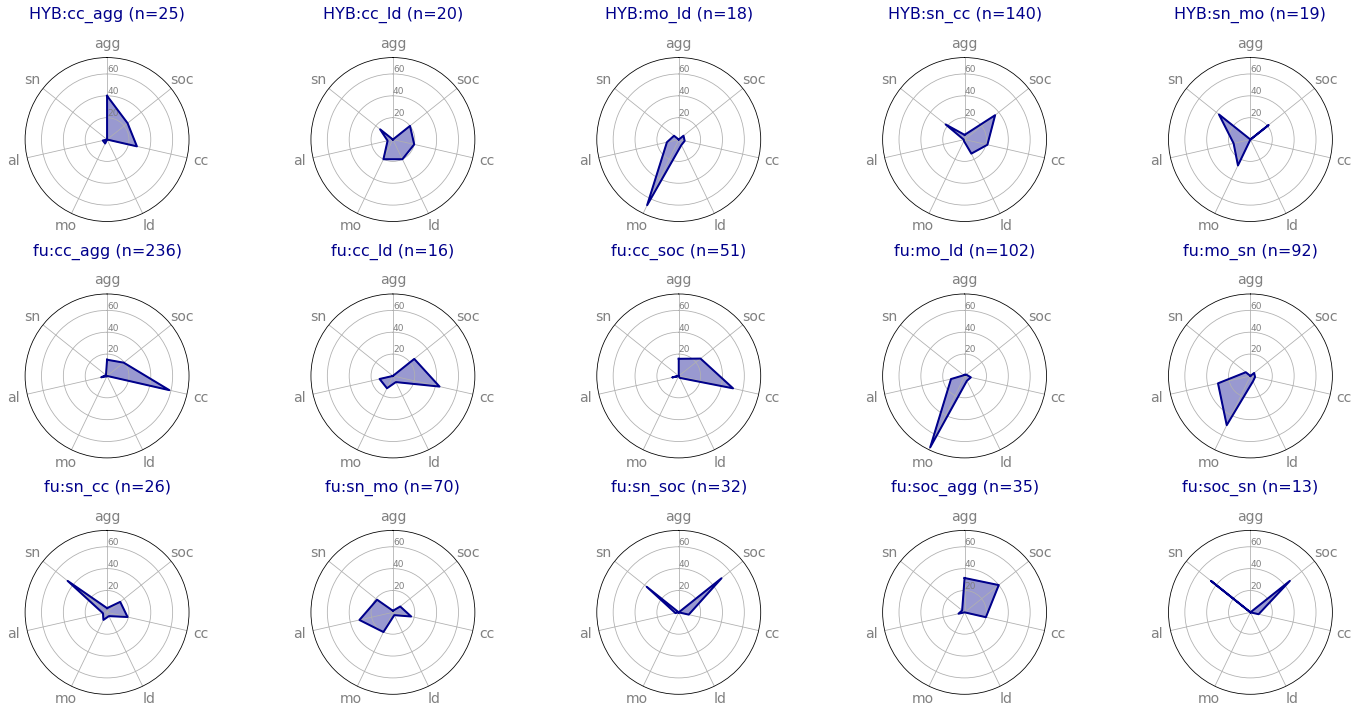

In [215]:
def make_spider(row, title, color):
    categories=list(grouped_filtered)[1:]
    N = len(categories)
  
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
  
    # Initialise the spider plot
    #plt.figure(facecolor='white')
    
    ax = plt.subplot(3,5,row+1, polar=True, facecolor="white")
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
  
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=14)
  
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([20,40,60], ["20","40", "60"], color="grey", size=9)
    #plt.yticks([25,50,75], ["25","50","75"], color="grey", size=9)
    #plt.ylim(0,100)
    plt.ylim(0,75)
  
    # Ind1
    values=grouped_filtered.loc[row].drop('label').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    plt.title(title, size=16, color=color, y=1.2)


# initialize the figure
my_dpi=96
#plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
plt.figure(figsize=(20,10), facecolor="white")

# Loop to plot
for row in range(0, len(grouped_filtered.index)):
    make_spider(row=row, title=grouped_filtered['label'][row]+" (n="+str(numbers_dict[grouped_filtered['label'][row]])+")", color="darkblue")

plt.tight_layout()
plt.savefig(os.path.join(os.path.sep, FIGURES,'hybfu.png'), facecolor="white")

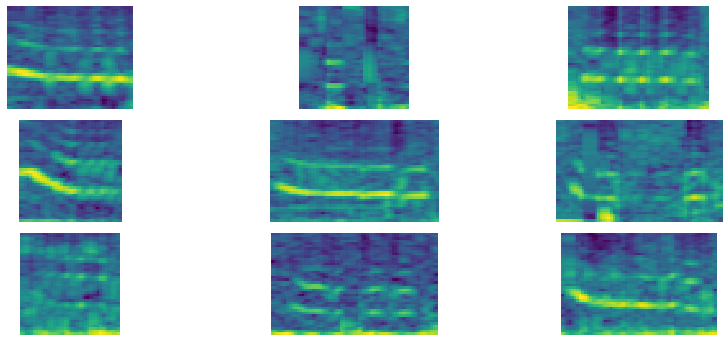

In [218]:
# Look at fu_soc_sn calls
call_of_interest = 'HYB:cc_ld'
# Visualize examples
df_subset = df_hybfu.loc[ambi_labels==call_of_interest,:].sample(9, replace=False)

specs = df_subset.denoised_spectrograms.values

plt.figure(figsize=(12, 8))
plt.title(call_of_interest)
k=1
for i in range(len(specs)):
  #spec = pad_spectro(specs[i], 134)
    spec = specs[i]
    plt.subplot(5, 3, k)
    plt.imshow(spec, interpolation='nearest', origin='lower', aspect='equal')
    plt.axis('off') 
    k=k+1
plt.tight_layout()
plt.savefig(os.path.join(os.path.sep,FIGURES,call_of_interest+'_examples.png'))

###Eval

In [219]:
grouped_filtered

,label,agg,soc,cc,ld,mo,al,sn
0,HYB:cc_agg,40.000000,24.000000,28.000000,0.000000,4.000000,4.000000,0.000000
1,HYB:cc_ld,0.000000,20.000000,20.000000,20.000000,20.000000,5.000000,15.000000
2,HYB:mo_ld,0.000000,5.555556,5.555556,5.555556,66.666667,11.111111,5.555556
3,HYB:sn_cc,4.285714,35.714286,21.428571,14.285714,1.428571,0.714286,22.142857
4,HYB:sn_mo,0.000000,21.052632,0.000000,0.000000,26.315789,15.789474,36.842105
5,fu:cc_agg,14.830508,19.491525,58.474576,0.000000,0.423729,5.508475,1.271186
6,fu:cc_ld,0.000000,25.000000,43.750000,6.250000,12.500000,12.500000,0.000000
7,fu:cc_soc,15.686275,25.490196,50.980392,1.960784,0.000000,5.882353,0.000000
8,fu:mo_ld,0.980392,1.960784,5.882353,4.901961,72.549020,12.745098,0.980392
9,fu:mo_sn,0.000000,4.347826,4.347826,5.434783,50.000000,30.434783,5.434783


In [220]:
hybfu_type = [i.split(':')[0] for i in grouped_filtered['label']] # fu or hyb
two_labels = [i.split(':')[1] for i in grouped_filtered['label']] 
first_lab = [i.split('_')[0] for i in two_labels] # first label
second_lab = [i.split('_')[1] for i in two_labels] # second label

In [221]:
# average percentage of k nearest neighbors that belongs to either one of the hybfu labels

correct_dict={}
correct_dict['HYB'] = 0
correct_dict['fu'] = 0

for i in range(grouped_filtered.shape[0]):
    add_val = grouped_filtered.loc[i, first_lab[i]] + grouped_filtered.loc[i, second_lab[i]] 
    correct_dict[hybfu_type[i]] = correct_dict[hybfu_type[i]] + add_val

In [222]:
correct_dict['HYB']/np.sum(np.asarray([1 if x=='HYB' else 0 for x in hybfu_type]))

57.390309106098584

In [223]:
correct_dict['fu']/np.sum(np.asarray([1 if x=='fu' else 0 for x in hybfu_type]))

68.7853743674217

How many of the calls had neighbors of both categories?

In [224]:
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,neighbor_id_2,neighbor_id_3,neighbor_id_4,neighbor_id_5,callID
0,HYB [LEAD + CC],HYB,ld,cc,sn,sn,sn,sn,sn,215,3009,3208,2907,3181,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
1,HYB [CC + LEAD],HYB,cc,ld,agg,soc,mo,soc,soc,4280,2155,561,4151,4154,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
2,HYB [CC + LEAD],HYB,cc,ld,soc,sn,mo,sn,sn,1305,927,3598,635,4738,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
3,HYB [CC + AGG],HYB,cc,agg,soc,agg,agg,agg,soc,1923,4357,4933,1262,1956,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...
4,HYB (SN+CC),HYB,sn,cc,ld,soc,soc,soc,soc,4927,787,2330,4897,2039,HM_HRT_R07_20170903-20170908_file_4_(2017_09_0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,HYB [CC+MOV],HYB,cc,mo,soc,cc,cc,sn,soc,4277,5430,5804,289,4137,HM_VLF206_SOUNDFOC_20170824_2_SS___1:15.173
989,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4655,4595,4696,4792,4915,HM_VLF206_SOUNDFOC_20170824_2_SS___1:26.758
990,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4761,4767,4634,4827,4721,HM_VLF206_SOUNDFOC_20170824_2_SS___1:29.641
991,HYB [CC+LD],HYB,cc,ld,cc,soc,cc,cc,cc,5582,3849,6026,6068,5105,HM_VLF206_SOUNDFOC_20170824_2_SS___1:40.316


In [225]:
hybfu_classi_neighbors = np.asarray(hybfu_classi[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
in_neighbors = [0]* hybfu_classi.shape[0]

for i in range(hybfu_classi.shape[0]):
    neighbors = hybfu_classi_neighbors[i,:]
    if ((hybfu_classi.loc[i,'first_label'] in neighbors) and (hybfu_classi.loc[i,'second_label'] in neighbors)):
        in_neighbors[i] = 1

hybfu_classi['both_in_neighbors'] = in_neighbors

In [226]:
hybfu_classi_neighbors = np.asarray(hybfu_classi[['neighbor_1', 'neighbor_2', 'neighbor_3', 'neighbor_4', 'neighbor_5']])
in_neighbors = [0]* hybfu_classi.shape[0]

for i in range(hybfu_classi.shape[0]):
    neighbors = hybfu_classi_neighbors[i,:]
    if ((hybfu_classi.loc[i,'first_label'] in neighbors) or (hybfu_classi.loc[i,'second_label'] in neighbors)):
        in_neighbors[i] = 1

hybfu_classi['any_in_neighbors'] = in_neighbors

In [227]:
from collections import Counter

pure_nbrhood = []

for i in range(hybfu_classi.shape[0]):
    words_to_count = hybfu_classi_neighbors[i,:].tolist()
    c = Counter(words_to_count)
    x= c.most_common(5)
  
    x_counts = np.asarray([x[1] for x in x])
    x_labs = np.asarray([x[0] for x in x])
    max_val = np.max(x_counts)
    if max_val==5:
        pure_nbrhood.append('yes')
    else:
        pure_nbrhood.append('no')

hybfu_classi['pure_nbrhood'] = pure_nbrhood

In [228]:
any_percent = {}
both_percent = {}
pure_percent = {}
total = {}

for selected_type in ['HYB', 'fu']:
    hybfu_subset = hybfu_classi.loc[hybfu_classi['hybfu_type']==selected_type]
    print(selected_type, ":", np.sum(hybfu_subset['any_in_neighbors']), "of", hybfu_subset.shape[0], "(",np.sum(hybfu_subset['any_in_neighbors'])/hybfu_subset.shape[0], ")" )
    any_percent[selected_type] = np.sum(hybfu_subset['any_in_neighbors'])/hybfu_subset.shape[0]*100
    both_percent[selected_type] = np.sum(hybfu_subset['both_in_neighbors'])/hybfu_subset.shape[0]*100
    pure_percent[selected_type] = hybfu_classi.loc[(hybfu_classi['hybfu_type']==selected_type) & (hybfu_classi['pure_nbrhood']=='yes')].shape[0]/hybfu_subset.shape[0]*100
    total[selected_type] = hybfu_subset.shape[0]

HYB : 189 of 256 ( 0.73828125 )
fu : 647 of 737 ( 0.8778833107191316 )


In [229]:
1-0.8664122137404581

0.13358778625954193

In [230]:
1-0.8311688311688312

0.16883116883116878

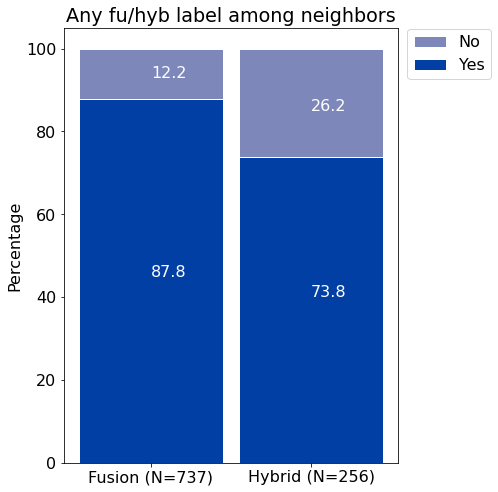

In [234]:
from matplotlib import rc

 # y-axis in bold
rc('font', weight='regular', size=16)
plt.figure(figsize=(6,8))
# Values of each group
bars1 = [any_percent['fu'],any_percent['HYB']]
bars2 = [100-any_percent['fu'], 100-any_percent['HYB']]


# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = [0,1]
 
# Names of group and bar width
names = ['Fusion (N='+str(total['fu'])+')',
         'Hybrid (N='+str(total['HYB'])+')']
barWidth = 0.9
 
# Create  bars
plt.bar(r, bars2, bottom=bars1, color="#7d87b9", edgecolor='white', width=barWidth, label="No")
plt.bar(r, bars1, color="#023fa5", edgecolor='white', width=barWidth, label="Yes")

lgd = plt.legend(bbox_to_anchor=(1.3, 0.94), loc='right')
plt.xticks(r, names, fontweight='regular')
plt.ylabel('Percentage')

plt.text(0,45,str(round(any_percent['fu'],1)), color="white")
plt.text(0,93,str(round((100-any_percent['fu']),1)), color="white")

plt.text(1,40,str(round(any_percent['HYB'],1)), color="white")
plt.text(1,85,str(round((100-any_percent['HYB']),1)),color="white")

plt.title('Any fu/hyb label among neighbors')
# Show graphic
#plt.show()
#plt.savefig(FIGURES+'hybfu_majorityvotes.png', dpi=1200)
plt.savefig(os.path.join(os.path.sep,FIGURES,'hybfu_majorityvotes.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')



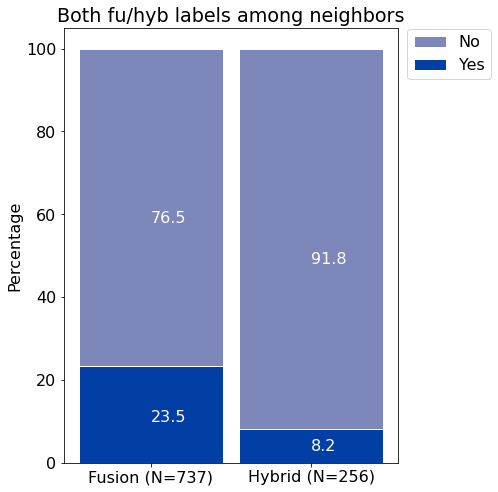

In [241]:
from matplotlib import rc

 # y-axis in bold
rc('font', weight='regular', size=16)
plt.figure(figsize=(6,8))
# Values of each group
bars1 = [both_percent['fu'],both_percent['HYB']]
bars2 = [100-both_percent['fu'], 100-both_percent['HYB']]

# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = [0,1]
 
# Names of group and bar width
names = ['Fusion (N='+str(total['fu'])+')',
         'Hybrid (N='+str(total['HYB'])+')']
barWidth = 0.9
 
# Create  bars
plt.bar(r, bars2, bottom=bars1, color="#7d87b9", edgecolor='white', width=barWidth, label="No")
plt.bar(r, bars1, color="#023fa5", edgecolor='white', width=barWidth, label="Yes")

lgd=plt.legend(bbox_to_anchor=(1.3, 0.94), loc='right')
plt.xticks(r, names, fontweight='regular')
plt.ylabel('Percentage')


plt.text(0,10,str(round(both_percent['fu'],1)), color="white")
plt.text(0,58,str(round((100-both_percent['fu']),1)), color="white")

plt.text(1,3,str(round(both_percent['HYB'],1)), color="white")
plt.text(1,48,str(round((100-both_percent['HYB']),1)),color="white")



plt.title('Both fu/hyb labels among neighbors')
# Show graphic
#plt.show()
#plt.savefig(FIGURES+'hybfu_majorityvotes.png', dpi=1200)
plt.savefig(os.path.join(os.path.sep,FIGURES,'hybfu_both_onlymixed.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')

No handles with labels found to put in legend.


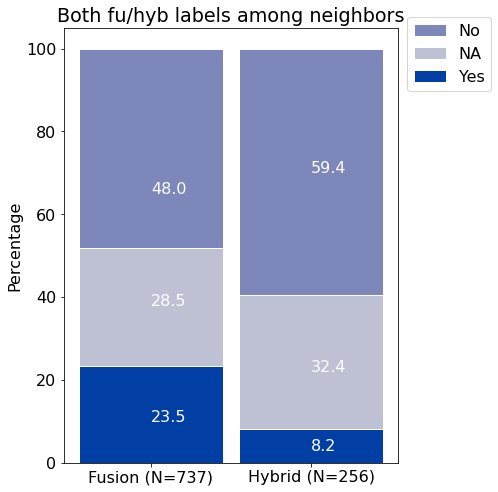

In [244]:
from matplotlib import rc

 # y-axis in bold
rc('font', weight='regular', size=16)
plt.figure(figsize=(6,8))
# Values of each group
bars1 = [both_percent['fu'],both_percent['HYB']]
bars2 = [pure_percent['fu'], pure_percent['HYB']]
bars3 = [100-(both_percent['fu']+pure_percent['fu']), 100-(both_percent['HYB']+pure_percent['HYB'])]

# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = [0,1]
 
# Names of group and bar width
names = ['Fusion (N='+str(total['fu'])+')',
         'Hybrid (N='+str(total['HYB'])+')']
barWidth = 0.9
 

lgd=plt.legend(bbox_to_anchor=(1.3, 0.92), loc='right')
plt.xticks(r, names, fontweight='regular')
plt.ylabel('Percentage')


# Create brown bars

# Create green bars (middle), on top of the firs ones
plt.bar(r, bars3, bottom=bars, color="#7d87b9", edgecolor='white', width=barWidth, label="No")
plt.bar(r, bars2, bottom=bars1, color="#bec1d4", edgecolor='white', width=barWidth, label="NA")
plt.bar(r, bars1, color="#023fa5", edgecolor='white', width=barWidth, label="Yes")
# Create green bars (top)
lgd=plt.legend(bbox_to_anchor=(1.3, 0.94), loc='right')
plt.xticks(r, names, fontweight='regular')
plt.ylabel('Percentage')




plt.text(0,10,str(round(bars1[0],1)), color="white")
plt.text(0,65,str(round(bars3[0],1)), color="white")
plt.text(0,38,str(round(bars2[0],1)), color="white")

plt.text(1,3,str(round(bars1[1],1)), color="white")
plt.text(1,70,str(round(bars3[1],1)),color="white")
plt.text(1,22,str(round(bars2[1],1)),color="white")



plt.title('Both fu/hyb labels among neighbors')
# Show graphic
#plt.show()
#plt.savefig(FIGURES+'hybfu_majorityvotes.png', dpi=1200)
plt.savefig(os.path.join(os.path.sep,FIGURES,'hybfu_both_withNA.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')

How many of the calls had majority neighbors of at least one of the two labels?

In [ ]:
from collections import Counter

In [245]:
majorityvote = []

for i in range(hybfu_classi.shape[0]):
    words_to_count = hybfu_classi_neighbors[i,:].tolist()
    c = Counter(words_to_count)
    x= c.most_common(5)
  
    
    x_counts = np.asarray([x[1] for x in x])
    x_labs = np.asarray([x[0] for x in x])
    max_val = np.max(x_counts)
    selector = np.where(x_counts==max_val)[0]
    majorityvote.append(x_labs[selector])

In [246]:
in_majority = []

for i in range(hybfu_classi.shape[0]):
    if (len(majorityvote[i])>1):
        in_majority.append('tie')
    else:
        in_majority.append(majorityvote[i][0])

In [247]:
# when ties count
in_majority = []

for i in range(hybfu_classi.shape[0]):
    if (len(majorityvote[i])==2):
    # any of these in label?
        if (hybfu_classi.loc[i,'first_label'] in majorityvote[i]):
            in_majority.append(hybfu_classi.loc[i,'first_label'])
        elif (hybfu_classi.loc[i,'second_label'] in majorityvote[i]):
            in_majority.append(hybfu_classi.loc[i,'second_label'])
        else:
            in_majority.append('tie')
    elif len(majorityvote[i])>2:
        in_majority.append('tie')
    else:
        in_majority.append(majorityvote[i][0])

In [248]:
lens = [len(x) for x in majorityvote]

In [249]:
pd.Series(lens).value_counts()

1    906
2     85
5      2
dtype: int64

In [250]:
hybfu_classi['in_majority'] = in_majority
hybfu_classi['majorityvote'] = majorityvote

In [251]:
majority_in_label = []

for i in range(hybfu_classi.shape[0]):
    majority = hybfu_classi.loc[i,'in_majority']
    if majority=='tie':
        majority_in_label.append('tie')
    elif ((majority==hybfu_classi.loc[i,'first_label']) or (majority==hybfu_classi.loc[i,'second_label'])):
        majority_in_label.append('yes')
    else:
        majority_in_label.append('no')

hybfu_classi['majority_in_label'] = majority_in_label
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,...,neighbor_id_3,neighbor_id_4,neighbor_id_5,callID,both_in_neighbors,any_in_neighbors,pure_nbrhood,in_majority,majorityvote,majority_in_label
0,HYB [LEAD + CC],HYB,ld,cc,sn,sn,sn,sn,sn,215,...,3208,2907,3181,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,0,yes,sn,[sn],no
1,HYB [CC + LEAD],HYB,cc,ld,agg,soc,mo,soc,soc,4280,...,561,4151,4154,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,0,no,soc,[soc],no
2,HYB [CC + LEAD],HYB,cc,ld,soc,sn,mo,sn,sn,1305,...,3598,635,4738,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,0,no,sn,[sn],no
3,HYB [CC + AGG],HYB,cc,agg,soc,agg,agg,agg,soc,1923,...,4933,1262,1956,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,1,no,agg,[agg],yes
4,HYB (SN+CC),HYB,sn,cc,ld,soc,soc,soc,soc,4927,...,2330,4897,2039,HM_HRT_R07_20170903-20170908_file_4_(2017_09_0...,0,0,no,soc,[soc],no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,HYB [CC+MOV],HYB,cc,mo,soc,cc,cc,sn,soc,4277,...,5804,289,4137,HM_VLF206_SOUNDFOC_20170824_2_SS___1:15.173,0,1,no,cc,"[soc, cc]",yes
989,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4655,...,4696,4792,4915,HM_VLF206_SOUNDFOC_20170824_2_SS___1:26.758,0,1,yes,mo,[mo],yes
990,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4761,...,4634,4827,4721,HM_VLF206_SOUNDFOC_20170824_2_SS___1:29.641,0,1,yes,mo,[mo],yes
991,HYB [CC+LD],HYB,cc,ld,cc,soc,cc,cc,cc,5582,...,6026,6068,5105,HM_VLF206_SOUNDFOC_20170824_2_SS___1:40.316,0,1,no,cc,[cc],yes


In [ ]:
#above10_labels = pd.DataFrame(pd.Series(hybfu_calls).value_counts()[pd.Series(hybfu_calls).value_counts()>10]).index.tolist()
#selector = [True if x in above10_labels else False for x in hybfu_calls]
#hybfu_classi = hybfu_classi.loc[selector,:]

In [252]:
eval_tab = np.zeros((3,2))
for i,selected_type in enumerate(['fu', 'HYB']):
    hybfu_subset = hybfu_classi[hybfu_classi['hybfu_type']==selected_type]
    print(selected_type)
    print(hybfu_subset['majority_in_label'].value_counts())
    eval_tab[:,i] = np.asarray(hybfu_subset['majority_in_label'].value_counts())
eval_tab = pd.DataFrame(eval_tab)
eval_tab.columns = ['fu', 'HYB']
eval_tab.index = ['yes', 'no', 'tie']
eval_tab

fu
yes    535
no     190
tie     12
Name: majority_in_label, dtype: int64
HYB
yes    143
no     105
tie      8
Name: majority_in_label, dtype: int64


,fu,HYB
yes,535.0,143.0
no,190.0,105.0
tie,12.0,8.0


In [253]:
eval_percent = eval_tab.copy()
eval_percent['fu'] = (eval_tab['fu'] / eval_tab['fu'].sum()) * 100
eval_percent['HYB'] = (eval_tab['HYB'] / eval_tab['HYB'].sum()) * 100
eval_percent

,fu,HYB
yes,72.591588,55.859375
no,25.780190,41.015625
tie,1.628223,3.125000


In [254]:
'Fusion (N='+str(int(np.sum(eval_tab.loc[:,'fu'])))+")"

'Fusion (N=737)'

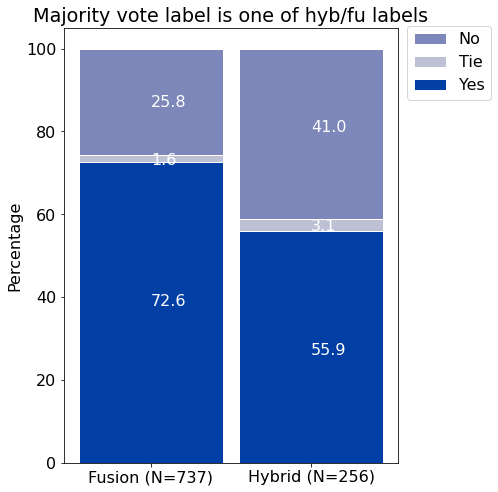

In [267]:
from matplotlib import rc

 # y-axis in bold
rc('font', weight='regular', size=16)
plt.figure(figsize=(6,8))
# Values of each group

bars1 = eval_percent.loc['yes',:]
bars2 = eval_percent.loc['tie',:]
bars3 = eval_percent.loc['no',:]

# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
 
# The position of the bars on the x-axis
r = [0,1]
 
# Names of group and bar width
names = ['Fusion (N='+str(int(np.sum(eval_tab.loc[:,'fu'])))+")",
         'Hybrid (N='+str(int(np.sum(eval_tab.loc[:,'HYB'])))+")"]
barWidth = 0.9
 
# Create bars
plt.bar(r, bars3, bottom=bars, color="#7d87b9", edgecolor='white', width=barWidth, label="No")
plt.bar(r, bars2, bottom=bars1, color="#bec1d4", edgecolor='white', width=barWidth, label="Tie")
plt.bar(r, bars1, color="#023fa5", edgecolor='white', width=barWidth, label="Yes")


lgd=plt.legend(bbox_to_anchor=(1.3, 0.92), loc='right')
plt.xticks(r, names, fontweight='regular')
plt.ylabel('Percentage')


plt.text(0,72,round(eval_percent.loc['tie','fu'],1), color="white")
plt.text(0,38,round(eval_percent.loc['yes','fu'],1), color="white")
plt.text(0,86,round(eval_percent.loc['no','fu'],1), color="white")

plt.text(1,56,round(eval_percent.loc['tie','HYB'],1), color="white")
plt.text(1,26,round(eval_percent.loc['yes','HYB'],1), color="white")
plt.text(1,80,round(eval_percent.loc['no','HYB'],1), color="white")

plt.title('Majority vote label is one of hyb/fu labels')
# Show graphic
#plt.show()
#plt.savefig(FIGURES+'hybfu_majorityvotes.png', dpi=1200)
plt.savefig(os.path.join(os.path.sep,FIGURES,'hybfu_majority_vote_ALL.png'), bbox_extra_artists=(lgd,), bbox_inches='tight')

In [262]:
hybfu_classi.loc[hybfu_classi['in_majority']=='tie',:]

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,...,neighbor_id_3,neighbor_id_4,neighbor_id_5,callID,both_in_neighbors,any_in_neighbors,pure_nbrhood,in_majority,majorityvote,majority_in_label
24,HYB (SN+CC),HYB,sn,cc,ld,ld,cc,soc,soc,621,...,6368,1326,523,HM_HRT_R07_20170903-20170908_file_4_(2017_09_0...,0,1,no,tie,"[ld, soc]",tie
41,HYB (SN+CC),HYB,sn,cc,ld,ld,mo,soc,mo,4210,...,4921,4131,868,HM_HRT_R07_20170903-20170908_file_4_(2017_09_0...,0,0,no,tie,"[ld, mo]",tie
47,HYB (SN+CC),HYB,sn,cc,ld,soc,soc,ld,cc,630,...,2235,634,5407,HM_HRT_R07_20170903-20170908_file_4_(2017_09_0...,0,1,no,tie,"[ld, soc]",tie
87,HYB (SN+MOVE),HYB,sn,mo,sn,soc,ld,agg,cc,333,...,4858,4062,5705,HM_HRT_R07_20170903-20170908_file_4_(2017_09_0...,0,1,no,tie,"[sn, soc, ld, agg, cc]",tie
89,HYB (SN+CC),HYB,sn,cc,agg,soc,soc,mo,agg,2277,...,4268,4819,2661,HM_HRT_R07_20170903-20170908_file_4_(2017_09_0...,0,0,no,tie,"[agg, soc]",tie
90,HYB [CC + AGG],HYB,cc,agg,soc,mo,agg,soc,mo,1477,...,665,2507,4647,HM_HRT_R09_AUDIO_file_4_(2017_08_23-06_44_59)_...,0,1,no,tie,"[soc, mo]",tie
112,HYB [SN+CC],HYB,sn,cc,ld,ld,cc,soc,soc,630,...,5407,863,2235,HM_HTB_R14_file_4_(2017_08_23-06_44_59)_ASWMUX...,0,1,no,tie,"[ld, soc]",tie
155,HYB (SN+CC),HYB,sn,cc,soc,ld,ld,mo,soc,920,...,4919,3671,4250,HM_LT_R09_20170903-20170908_file_4_(2017_09_05...,0,0,no,tie,"[soc, ld]",tie
209,fu cc+mo,fu,cc,mo,agg,soc,cc,agg,soc,1893,...,5286,4279,1974,HM_VCVM001_SOUNDFOC_HM_20190717-027___1:29:26.153,0,1,no,tie,"[agg, soc]",tie
299,fu cc+agg,fu,cc,agg,al,agg,soc,al,soc,2949,...,570,93,2569,HM_VHMF001_HTB_R20_20190707-20190719_file_6_(2...,0,1,no,tie,"[al, soc]",tie


In [263]:
hybfu_classi.to_pickle(os.path.join(os.path.sep,DATA,'2021-07-30-hybfu_classi'))

# Example calls

* Show examples for ties
* Show examples for clear associations
* Show nearest neighbors -> need to re-do project-transform.

In [ ]:
hybfu_classi['hybfu_rownum'] = np.arange(0,hybfu_classi.shape[0],1)
hybfu_classi['hybfu_label'] = hybfu_classi['hybfu_type'].map(str) + ':' + hybfu_classi['first_label'].map(str) + '_' + hybfu_classi['second_label'].map(str)

In [ ]:
df_hybfu = pd.read_pickle(DATA+'focal_hybfu_df')
df_hybfu.reset_index(inplace=True)

In [ ]:
subset = hybfu_classi.loc[hybfu_classi['in_majority']=='tie',:]

In [ ]:
subset = hybfu_classi.loc[hybfu_classi['majority_in_label']=='no',:]

In [ ]:
subset = hybfu_classi.loc[hybfu_classi['majority_in_label']=='yes',:]
examples = subset.sample(n=3, replace=False)
examples

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,index_id,neighbor_id_1,neighbor_id_2,neighbor_id_3,neighbor_id_4,neighbor_id_5,in_neighbors,both_in_neighbors,any_in_neighbors,in_majority,majority_in_label,hybfu_rownum,hybfu_label
76,HYB (SN+CC),HYB,sn,cc,cc,cc,cc,cc,cc,27321,6294,5540,5697,6582,5586,0,0,1,cc,yes,76,HYB:sn_cc
826,fu s+soc *,fu,sn,soc,agg,soc,sn,sn,sn,28116,2007,1838,589,1414,3920,1,1,1,sn,yes,826,fu:sn_soc
658,fu s+soc *,fu,sn,soc,soc,soc,soc,soc,soc,27927,1995,4231,4133,4184,4357,0,0,1,soc,yes,658,fu:sn_soc


In [ ]:
df.head(3)

,index,Name,Start,Duration,Time Format,Type,Description,call_yn,start_s,duration_s,stop_s,date,samplerate_hz,indv,original_wav,bout_number,call_lable,raw_audio,spectrograms,mfccs,mfcc_deltas,mfcc_deltadeltas,soundfoc_yn,stretched_spectrograms,stretched_mfccs,stretched_mfcc_deltas,stretched_mfcc_deltadeltas,denoised_spectrograms,denoised_stretched_spectrograms,denoised_mfccs,denoised_stretched_mfccs,denoised_mfcc_deltas,denoised_stretched_mfcc_deltas,certain_yn,index_id,nonfocal_yn
0,1598,ALARM,1:10:56.215,0:00.178,decimal,Cue,NaN,y,4256.215,0.178,4256.393,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,36,al,"[0.0, 0.001953125, 0.001953125, 0.0, -0.001953...","[[-7.209921, -5.1646175, -3.098959, -2.4054718...","[[-191.47098, -187.8111, -185.9428, -190.7444,...","[[-0.20289917, -0.20289917, -0.20289917, -0.20...","[[0.52968067, 0.52968067, 0.52968067, 0.529680...",n,"[[-7.011978, -9.6945915, -19.352905, -4.998459...","[[-298.56454, -287.705, -251.56706, -233.63583...","[[8.501973, 8.501973, 8.501973, 8.501973, 8.50...","[[-4.471219, -4.471219, -4.471219, -4.471219, ...","[[25.639555, 26.477575, 27.715773, 28.758339, ...","[[42.728127, 36.027912, 21.339691, 33.3617, 33...","[[16.28734, 12.311697, 8.946664, 6.3528423, 1....","[[16.01946, 1.4694939, 5.795529, 8.975101, 7.6...","[[-0.61669123, -0.61669123, -0.61669123, -0.61...","[[-1.8924303, -1.8924303, -1.8924303, -1.89243...",y,1598,n
1,1599,ALARM,1:12:04.643,0:00.317,decimal,Cue,NaN,y,4324.643,0.317,4324.960,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,37,al,"[-0.001953125, 0.0, -0.001953125, 0.001953125,...","[[-21.059677, -20.16883, -20.029144, -18.70754...","[[-202.54906, -200.67754, -198.63663, -195.151...","[[2.8926115, 2.8926115, 2.8926115, 2.8926115, ...","[[0.34753123, 0.34753123, 0.34753123, 0.347531...",n,"[[-20.856384, -25.17736, -22.190731, -18.3026,...","[[-309.39282, -302.25238, -261.8284, -244.5711...","[[9.903481, 9.903481, 9.903481, 9.903481, 9.90...","[[-5.0388603, -5.0388603, -5.0388603, -5.03886...","[[10.762169, 11.25013, 11.792789, 12.15715, 16...","[[31.449883, 24.311474, 19.03553, 20.888477, 1...","[[-1.2900445, -1.9665908, 2.6229572, 0.0544083...","[[21.421076, 10.742476, -1.0906525, 3.2950172,...","[[0.75837135, 0.75837135, 0.75837135, 0.758371...","[[-2.5341513, -2.5341513, -2.5341513, -2.53415...",y,1599,n
2,1600,ALARM,1:12:15.132,0:00.192,decimal,Cue,NaN,y,4335.132,0.192,4335.324,2017-08-23,8000,HMB,/content/drive/My Drive/meerkat/in_wavs/HM_HMB...,38,al,"[0.005859375, 0.005859375, 0.0078125, 0.005859...","[[-13.698711, -14.600319, -16.215317, -15.7289...","[[-228.33861, -223.5106, -216.6013, -210.05571...","[[5.747422, 5.747422, 5.747422, 5.747422, 5.74...","[[-0.56166244, -0.56166244, -0.56166244, -0.56...",n,"[[-18.871624, -18.160267, -16.079659, -15.3467...","[[-332.1619, -317.1976, -282.9387, -259.3602, ...","[[8.739941, 8.739941, 8.739941, 8.739941, 8.73...","[[-4.272333, -4.272333, -4.272333, -4.272333, ...","[[24.188335, 22.856678, 18.059265, 18.200275, ...","[[34.815525, 32.16957, 28.692219, 25.785461, 2...","[[11.280135, 13.388241, 0.17019328, 4.531397, ...","[[7.3854628, 1.116233, 0.22352138, 0.7825685, ...","[[0.3497859, 0.3497859, 0.3497859, 0.3497859, ...","[[-0.8115787, -0.8115787, -0.8115787, -0.81157...",y,1600,n


In [ ]:
neighbor_rownums = [examples.loc[0,'neighbor_id_'+str(x)] for x in [1,2,3,4,5]]
neighbor_specs = [df.loc[nb_rn, 'denoised_spectrograms'] for nb_rn in neighbor_rownums]

In [294]:
call = hybfu_classi.callID.values[0]
df_hybfu.loc[df_hybfu.callID==call,'spectrograms'].values[0]

(40, 53)

In [295]:
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,...,neighbor_id_3,neighbor_id_4,neighbor_id_5,callID,both_in_neighbors,any_in_neighbors,pure_nbrhood,in_majority,majorityvote,majority_in_label
0,HYB [LEAD + CC],HYB,ld,cc,sn,sn,sn,sn,sn,215,...,3208,2907,3181,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,0,yes,sn,[sn],no
1,HYB [CC + LEAD],HYB,cc,ld,agg,soc,mo,soc,soc,4280,...,561,4151,4154,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,0,no,soc,[soc],no
2,HYB [CC + LEAD],HYB,cc,ld,soc,sn,mo,sn,sn,1305,...,3598,635,4738,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,0,no,sn,[sn],no
3,HYB [CC + AGG],HYB,cc,agg,soc,agg,agg,agg,soc,1923,...,4933,1262,1956,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,1,no,agg,[agg],yes
4,HYB (SN+CC),HYB,sn,cc,ld,soc,soc,soc,soc,4927,...,2330,4897,2039,HM_HRT_R07_20170903-20170908_file_4_(2017_09_0...,0,0,no,soc,[soc],no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,HYB [CC+MOV],HYB,cc,mo,soc,cc,cc,sn,soc,4277,...,5804,289,4137,HM_VLF206_SOUNDFOC_20170824_2_SS___1:15.173,0,1,no,cc,"[soc, cc]",yes
989,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4655,...,4696,4792,4915,HM_VLF206_SOUNDFOC_20170824_2_SS___1:26.758,0,1,yes,mo,[mo],yes
990,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4761,...,4634,4827,4721,HM_VLF206_SOUNDFOC_20170824_2_SS___1:29.641,0,1,yes,mo,[mo],yes
991,HYB [CC+LD],HYB,cc,ld,cc,soc,cc,cc,cc,5582,...,6026,6068,5105,HM_VLF206_SOUNDFOC_20170824_2_SS___1:40.316,0,1,no,cc,[cc],yes


In [301]:
param = 'no'
subset = hybfu_classi.loc[hybfu_classi['majority_in_label']==param,:]
examples = subset.sample(n=5, replace=False, random_state=2204)
examples
examples.index.values

array([489, 814,  93, 316, 556])

In [316]:
hybfu_classi

,Name,hybfu_type,first_label,second_label,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,neighbor_id_1,...,neighbor_id_3,neighbor_id_4,neighbor_id_5,callID,both_in_neighbors,any_in_neighbors,pure_nbrhood,in_majority,majorityvote,majority_in_label
0,HYB [LEAD + CC],HYB,ld,cc,sn,sn,sn,sn,sn,215,...,3208,2907,3181,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,0,yes,sn,[sn],no
1,HYB [CC + LEAD],HYB,cc,ld,agg,soc,mo,soc,soc,4280,...,561,4151,4154,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,0,no,soc,[soc],no
2,HYB [CC + LEAD],HYB,cc,ld,soc,sn,mo,sn,sn,1305,...,3598,635,4738,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,0,no,sn,[sn],no
3,HYB [CC + AGG],HYB,cc,agg,soc,agg,agg,agg,soc,1923,...,4933,1262,1956,HM_HRT_R07_20170903-20170908_file_2_(2017_09_0...,0,1,no,agg,[agg],yes
4,HYB (SN+CC),HYB,sn,cc,ld,soc,soc,soc,soc,4927,...,2330,4897,2039,HM_HRT_R07_20170903-20170908_file_4_(2017_09_0...,0,0,no,soc,[soc],no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,HYB [CC+MOV],HYB,cc,mo,soc,cc,cc,sn,soc,4277,...,5804,289,4137,HM_VLF206_SOUNDFOC_20170824_2_SS___1:15.173,0,1,no,cc,"[soc, cc]",yes
989,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4655,...,4696,4792,4915,HM_VLF206_SOUNDFOC_20170824_2_SS___1:26.758,0,1,yes,mo,[mo],yes
990,HYB [MOV+LD],HYB,mo,ld,mo,mo,mo,mo,mo,4761,...,4634,4827,4721,HM_VLF206_SOUNDFOC_20170824_2_SS___1:29.641,0,1,yes,mo,[mo],yes
991,HYB [CC+LD],HYB,cc,ld,cc,soc,cc,cc,cc,5582,...,6026,6068,5105,HM_VLF206_SOUNDFOC_20170824_2_SS___1:40.316,0,1,no,cc,[cc],yes


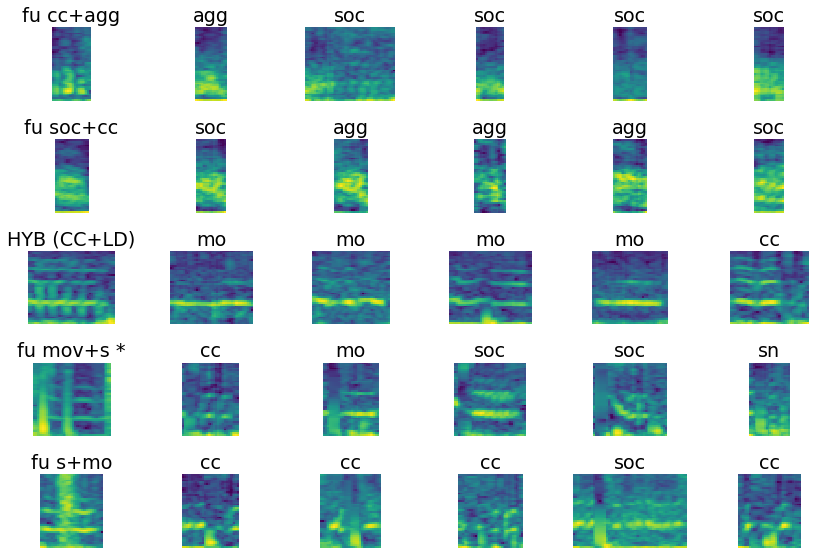

In [319]:
# Visualize examples
param = 'no'
subset = hybfu_classi.loc[hybfu_classi['majority_in_label']==param,:]
examples = subset.sample(n=5, replace=False, random_state=2204)

hybfu_rownums = examples.index.values
hybfu_specs = [df_hybfu.iloc[x, :].spectrograms for x in hybfu_rownums]
hybfu_labels = examples.Name.values
examples.reset_index(inplace=True)

plt.figure(figsize=(12, 8))
k=1
for i,hybfu_spec in enumerate(hybfu_specs):
    plt.subplot(5, 6, k)
    plt.imshow(hybfu_spec, interpolation='nearest', origin='lower', aspect='equal')
    plt.axis('off')
    plt.title(hybfu_labels[i])
    k=k+1
    neighbor_rownums = [examples.loc[i,'neighbor_id_'+str(x)] for x in [1,2,3,4,5]]
    neighbor_specs = [df.loc[nb_rn, 'denoised_spectrograms'] for nb_rn in neighbor_rownums]
    neighbor_labels = [df.loc[nb_rn, 'call_lable'] for nb_rn in neighbor_rownums]

    for nb_spec, nb_label in zip(neighbor_specs, neighbor_labels):
        plt.subplot(5, 6, k)
        plt.imshow(nb_spec, interpolation='nearest', origin='lower', aspect='equal')
        plt.title(nb_label)
        plt.axis('off') 
        k=k+1

plt.tight_layout()
plt.savefig(os.path.join(os.path.sep,FIGURES,'mvote_'+param+'_examples.png'), facecolor="white")

# Old stuff

In [ ]:
k=10

# Find k nearest neighbors
nbrs = NearestNeighbors(metric='euclidean',n_neighbors=k+1, algorithm='brute').fit(embed)
distances, indices = nbrs.kneighbors(embedding)

# need to remove the first neighbor, because that is the datapoint itself
indices = indices[:,1:]  
distances = distances[:,1:]

In [ ]:
labels = df.call_lable
labelnames = df.Name

In [ ]:
fu_hyb_indices = np.asarray(np.where(labels=='fu/hyb'))[0]

In [ ]:
fu_hyb_indices = np.asarray(np.where(labels=='fu/hyb'))[0]

for i,ind in enumerate(fu_hyb_indices):
  nearest_neighbors = indices[ind]
  neighbor_labels = [labels[neighbor] for neighbor in nearest_neighbors]
  print(labelnames[ind], " : ", neighbor_labels)

HYB [LEAD + CC]  :  ['fu/hyb', 'soc', 'fu/hyb', 'ld', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb']
HYB [CC + LEAD]  :  ['soc', 'fu/hyb', 'fu/hyb', 'ld', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'cc']
HYB [CC + LEAD]  :  ['fu/hyb', 'soc', 'cc', 'cc', 'fu/hyb', 'fu/hyb', 'soc', 'fu/hyb', 'fu/hyb', 'ld']
HYB [CC + AGG]  :  ['agg', 'agg', 'agg', 'agg', 'soc', 'soc', 'agg', 'fu/hyb', 'soc', 'fu/hyb']
HYB (SN+CC)  :  ['fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb']
HYB (SN+CC)  :  ['sn', 'fu/hyb', 'sn', 'fu/hyb', 'sn', 'ld', 'soc', 'soc', 'soc', 'ld']
HYB (SN+CC)  :  ['mo', 'sn', 'fu/hyb', 'sn', 'sn', 'sn', 'sn', 'mo', 'mo', 'sn']
HYB (SN+CC)  :  ['fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb']
HYB (SN+CC)  :  ['agg', 'soc', 'agg', 'agg', 'agg', 'agg', 'agg', 'agg', 'soc', 'soc']
HYB (SN+CC)  :  ['fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 'fu/hyb', 

In [ ]:
fu_hyb_indices = np.asarray(np.where(df.call_lable=='fu/hyb'))[0]

nn_stats_dict = {}
calltypes = sorted(list(set(labels)))
labels = np.asarray(labels)

for calltype in calltypes:
  call_indices = np.asarray(np.where(labels==calltype))[0]
  calltype_counts = np.zeros((call_indices.shape[0],len(calltypes)))

  for i,ind in enumerate(call_indices):
    nearest_neighbors = indices[ind]
    for neighbor in nearest_neighbors:
      neighbor_label = labels[neighbor]
      calltype_counts[i,np.where(np.asarray(calltypes)==neighbor_label)[0][0]] += 1 
  nn_stats_dict[calltype] = calltype_counts